# 1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [4]:
import cv2
import imghdr

C:\Users\Administrator\AppData\Local\Temp\ipykernel_11892\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 580 files belonging to 4 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

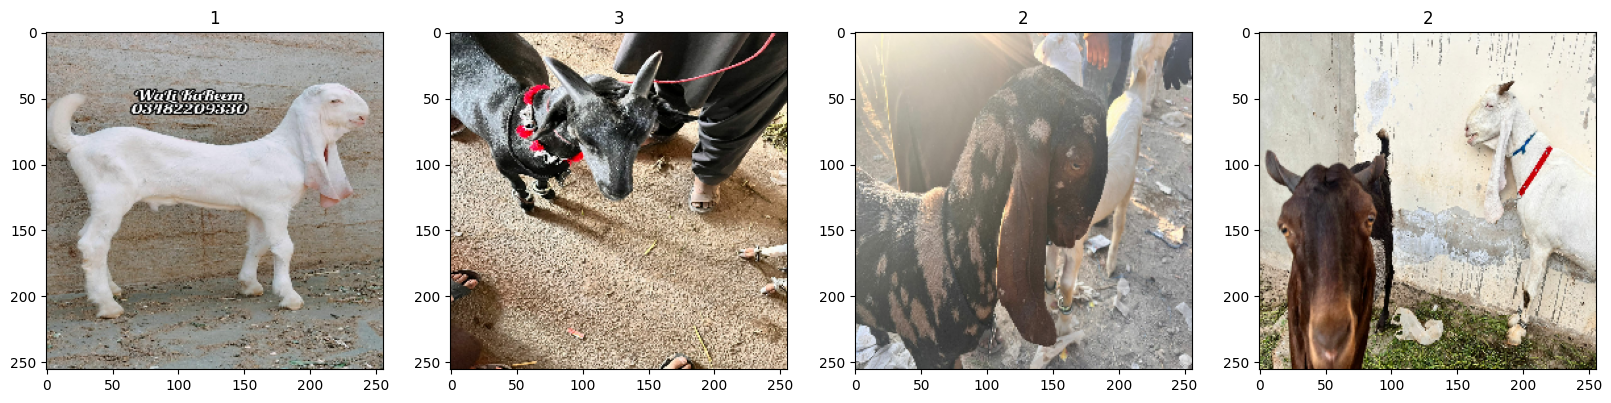

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x, y: (x / 255, tf.one_hot(y, depth=4)))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.34214154, 0.39312193, 0.42841604],
          [0.34159008, 0.39257047, 0.42786458],
          [0.33475795, 0.38573834, 0.4210325 ],
          ...,
          [0.8192402 , 0.7721814 , 0.7251226 ],
          [0.7752451 , 0.72818625, 0.6811274 ],
          [0.7997549 , 0.7526961 , 0.7056373 ]],
 
         [[0.39151347, 0.4424939 , 0.477788  ],
          [0.33901656, 0.38999695, 0.42529106],
          [0.21518075, 0.26616114, 0.30145526],
          ...,
          [0.77953434, 0.7324755 , 0.68541664],
          [0.78416055, 0.73710173, 0.6900429 ],
          [0.7814951 , 0.7344363 , 0.68737745]],
 
         [[0.28178614, 0.33325675, 0.36953124],
          [0.24414828, 0.29512867, 0.3304228 ],
          [0.17616421, 0.22567402, 0.26096815],
          ...,
          [0.78030026, 0.73324144, 0.6852022 ],
          [0.7904105 , 0.7433517 , 0.6953125 ],
          [0.7958946 , 0.7488358 , 0.70079654]],
 
         ...,
 
         [[0.98904717, 0.8211397 , 0.39010417],
          [0.92496

# 5. Split Data

In [15]:
# 5. Split Data
train_size = int(len(data) * 0.8)
val_size = int(len(data) * 0.3)
test_size = int(len(data) * 0.3)

In [16]:
train_size

15

In [17]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# 6. Build Deep Learning Model

In [18]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.30))
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.30))
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.30))
model.add(Flatten())
model.add(Dense(4, activation='softmax'))

In [22]:
from tensorflow.keras.losses import CategoricalCrossentropy 
from tensorflow.keras.metrics import Precision, Recall
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy', Precision(), Recall()])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 32)        0

# 7. Train

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


15/15 [==============================] - 19s 1s/step - loss: 1.9887 - accuracy: 0.3812 - precision: 0.3852 - recall: 0.2271 - val_loss: 1.3692 - val_accuracy: 0.5800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
15/15 [==============================] - 12s 700ms/step - loss: 1.2422 - accuracy: 0.4958 - precision: 0.9000 - recall: 0.0188 - val_loss: 1.1991 - val_accuracy: 0.3200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
15/15 [==============================] - 15s 894ms/step - loss: 1.1288 - accuracy: 0.5396 - precision: 0.5902 - recall: 0.0750 - val_loss: 1.1026 - val_accuracy: 0.4000 - val_precision: 0.9444 - val_recall: 0.1700
Epoch 4/20
15/15 [==============================] - 16s 900ms/step - loss: 0.9351 - accuracy: 0.6167 - precision: 0.7366 - recall: 0.4021 - val_loss: 0.9345 - val_accuracy: 0.5400 - val_precision: 0.6481 - val_recall: 0.3500
Epoch 5/20
15/15 [==============================] - 13s 758ms/step - loss: 0.7708 - a

# 8. Plot Performance

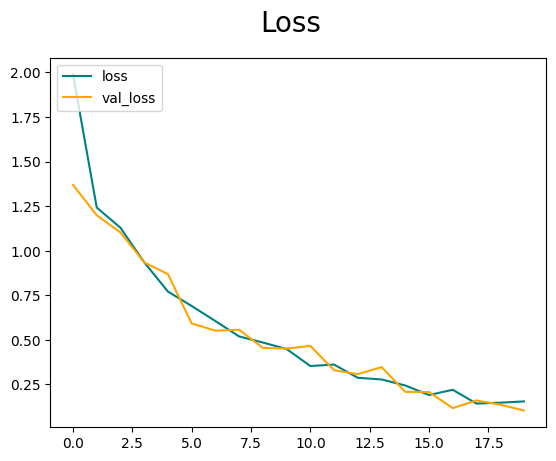

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

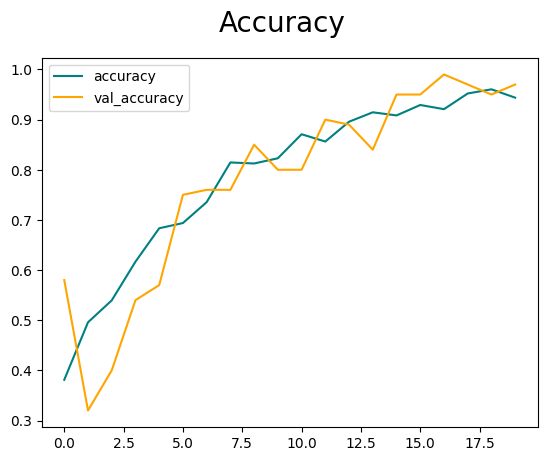

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [29]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [30]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [31]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [32]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


# 10. Test

In [33]:
import cv2

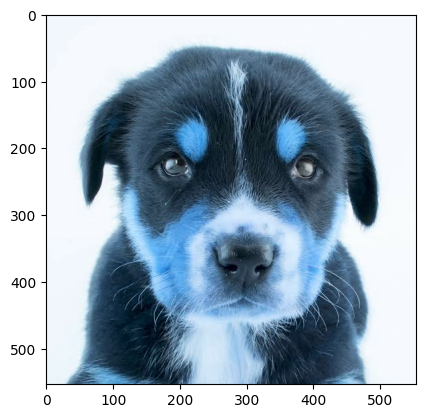

In [34]:
img = cv2.imread('dog.jpg')
if img is not None:
    plt.imshow(img)
    plt.show()
else:
    print("Error loading image.")


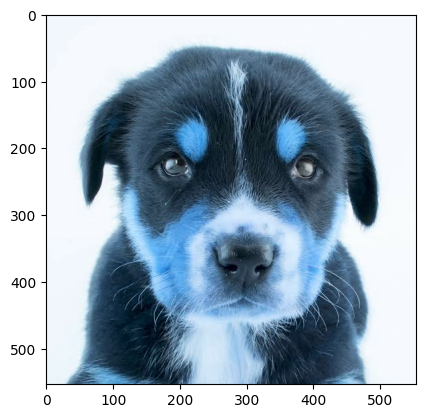

In [35]:
img = cv2.imread('dog.jpg')
plt.imshow(img)
plt.show()

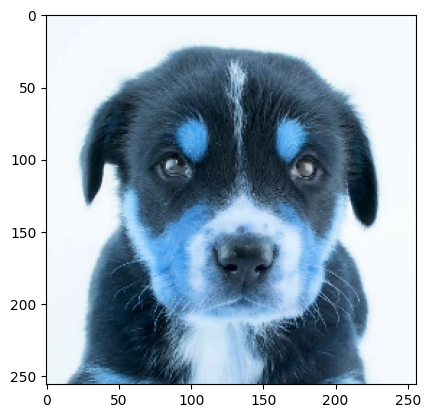

In [36]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [37]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 375ms/step


In [38]:
yhat

array([[0.00396541, 0.02695424, 0.03962546, 0.92945486]], dtype=float32)

In [39]:
if (yhat > 0.5).any():
    predicted_class = np.argmax(yhat)
    
    if predicted_class == 0:
        print(f'Predicted class is Gulabi')
    elif predicted_class == 1:
        print(f'Predicted class is Teddy')
    elif predicted_class == 2:
        print(f'Predicted class is MakkahCheeni')
    elif predicted_class == 3:
        print(f'Predicted class is Kamori')  
    else:
        print(f'Predicted class is Wrong')
else:
    print(f'Predicted class is Wrong')


Predicted class is Kamori


# 11. Save the Model

In [40]:
from tensorflow.keras.models import load_model

In [41]:
model.save(os.path.join('models','breedclassifier.h5'))

d:\FYP\ImageClassification\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
new_model = load_model('breedclassifier.h5')

OSError: No file or directory found at breedclassifier.h5

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))